In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd import grad
import seaborn as sns
import pandas as pd

# Problem to solve

In order to illustrate the methodology, we solve this easy problem

$$
\min_{x} f(x,y) = 4x + y ^ 2
$$

subject to

$$
y = g(x,y) = \min_y 3(y-x)^2
$$

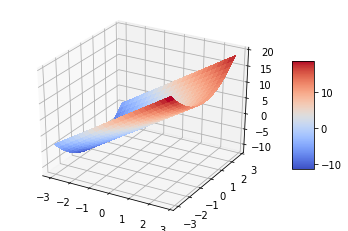

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')
k = -1.0

# Make data.
X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = 4*X + Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


The optimal solution for the inner problem is $y = x$. Then the outer problem becomes

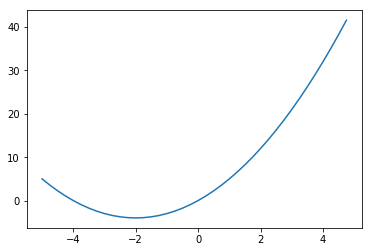

In [14]:
X = np.arange(-5, 5, 0.25)
Z = 4*X + X**2

plt.plot(X, Z)
plt.show()

And the optimal solution is $x = -2$. Let's try to get to this solution using gradient descent methods

## Approach based on implicit function theorem

In [15]:
def f(x,y):
    return(4*x + y**2)

def g(x,y):
    return(3*(y-x)**2)

def gy(x,y):  #partial derivative of g wrt y
    return(6*(y-x))

def gxy(x,y):  #partial derivative of g wrt y and then x
    return(-6)

def gyy(x,y):  #partial derivative of g wrt y twice
    return(6)

We need to compute $\frac{df(x,y)}{dx}$, that is

$$
\frac{df(x,y)}{dx} = \frac{\partial f}{\partial x} + \frac{\partial f}{\partial y}\frac{d y}{d x} = 4 + 2y\frac{\partial y}{\partial x}
$$

For this, we need $\frac{\partial y}{\partial x}$, where $y$ is the solution to $\frac{\partial g(x,y)}{\partial y} = 0$. This defines $y(x)$ implicitly. Using the implicit function theorem we have that

$$
\frac{dy}{dx} = - \frac{ \frac{\partial^2 g(x,y)}{\partial x\partial y} }{ \frac{\partial^2 g(x,y)}{\partial y^2} } = 1
$$

Thus we can use gradient descent

$$
x_t = x_{t-1} - \eta \frac{df(x,y)}{dx}\Big\vert_{x = x_{t-1}}
$$

In [764]:
T = 100 #Number of epochs
lr = 0.1 #Learning rate
xt = np.zeros(T)
x = 4.0 #Initial point


for i in range(T):
    # First we should evaluate y*(x_0) and its derivative
    xt[i] = x
    y = 3.0
    for j in range(T):
        y = y - lr*6*(y-x)
    
    yx = -gxy(x,y) / gyy(x,y) 
    
    x = x - lr*(4 + 2*y*yx)

    


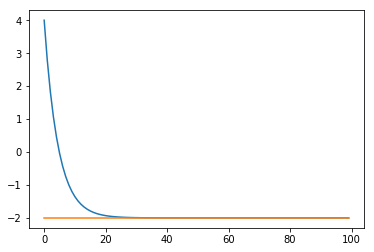

In [765]:
d = -2
x = np.arange(T)
plt.plot(x, xt)
plt.plot(x, np.zeros_like(x) + d)
plt.show()

## Approach based on forward mode computation

We substitute the inner problem by a dynamical system:

$$
\min_x f(x, y=y_T(x))
$$
    
where $y_t = \psi_t(y_{t-1},x) = y_{t-1} - \eta \frac{\partial g(x, y)}{\partial y}\Big\vert_{y=y_{t-1}}$. For each $x$, we need to compute $\frac{df(x,y_T)}{dx}$, that is

$$
\frac{df(x,y_T)}{dx} = \frac{\partial f}{\partial x} + \frac{\partial f}{\partial y_T}\frac{d y_T}{d x} = 4 + 2y_T\frac{d y_T}{d x}
$$

The only thing that remains is $\frac{d y_T}{d x}$ is recursively defined since for every $t$

$$
\frac{d y_t}{d x} = \frac{\partial \psi_t(y_{t-1},x)}{\partial x} + \frac{\partial \psi_t(y_{t-1},x)}{\partial y_{t-1}} \frac{d y_{t-1}}{dx}. 
$$

Let's call $A_t = \frac{\partial \psi_t(y_{t-1},x)}{\partial y_{t-1}}$ and $B_t = \frac{\partial \psi_t(y_{t-1},x)}{\partial x}$. In our particular case $A_t = 1 - 6\eta$ and $B_t = 6 \eta$. We also define $Z_t = \frac{d y_t}{dx}$. Thus,

$$
Z_t = B_t + A_t Z_{t-1}
$$

In [766]:
def A(x,y,lr):
    return(1 - 6*lr)

def B(x,y,lr):
    return(6*lr)

In [767]:
T = 100 #Number of epochs
lr = 0.1 # Outer learning rate
ilr = 0.1 # Inner learning rate
xt = np.zeros(T)
x = 4.0 #Initial point


for i in range(T):
    # We nee to compute the total derivative of f wrt x
    xt[i] = x
    y = 0.0
    Z = 0.0 #To store the derivatives of the dynamical system 
    for j in range(T):
        y = y - lr*gy(x,y)
        Z = Z*A(x,y,ilr) + B(x,y,ilr)
        
    x = x - lr*(4 + 2*y*Z)


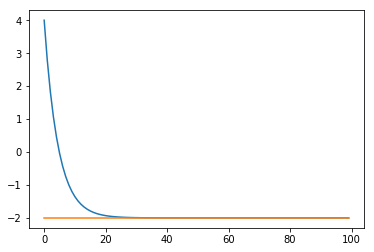

In [768]:
d = -2
x = np.arange(T)
plt.plot(x, xt)
plt.plot(x, np.zeros_like(x) + d)
plt.show()

## Approach based on backward mode computation

In [769]:
T = 100#Number of epochs
lr = 0.1 # Outer learning rate
ilr = 0.1 # Inner learning rate
xt = np.zeros(T)
x = 4.0 #Initial point

for i in range(T):
    # We nee to compute the total derivative of f wrt x
    xt[i] = x
    y = 0.0
    for j in range(T):
        y = y - lr*gy(x,y)
    ###
    lt = -(2*y)
    der = 0.0
    for j in range(T-1):
        der += lt*(-6.0*ilr)
        lt = lt*(1.0 - ilr*6.0)    

    x = x - lr*(4.0 + der)
    
print(x)


-1.9999999987777781


# Time Comparison

In [770]:
def do_forward(x, T):
    for i in range(T):
        # We nee to compute the total derivative of f wrt x
        y = 0.0
        Z = 0.0 #To store the derivatives of the dynamical system 
        for j in range(T):
            y = y - lr*gy(x,y)
            #Z = Z*A(x,y,ilr) + B(x,y,ilr)
            Z = Z*(1.0 - ilr*6.0) + (6.0*ilr)
        x = x - lr*(4 + 2*y*Z)
    return(x)

In [771]:
def do_backward(x, T):
    for i in range(T):
        # We nee to compute the total derivative of f wrt x
        y = 0.0
        for j in range(T):
            y = y - lr*gy(x,y)
        ###
        lt = -(2*y)
        der = 0.0
        for j in range(T-1):
            der += lt*(-6.0*ilr)
            lt = lt*(1.0 - ilr*6.0)    

        x = x - lr*(4.0 + der)
    return(x)

In [772]:
%timeit do_backward(1, 100)

3.42 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [773]:
%timeit do_forward(1, 100)

2.96 ms ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [774]:
do_forward(1,100)

-1.9999999993888893

In [775]:
do_backward(1,100)

-1.9999999993888886

# Using Autograd

### Forward mode

In [1087]:
T = 50 #Number of epochs
lr = 0.1 # Outer learning rate
ilr = 0.1 # Inner learning rate
xt = np.zeros(T)
x = Variable(torch.Tensor([0.0]), requires_grad=True)
y = Variable(torch.Tensor([0.0]), requires_grad=True)
##


for i in range(T):
    # We nee to compute the total derivative of f wrt x
    xt[i] = x
    #y = 0.0
    Z = 0.0 #To store the derivatives of the dynamical system 
    for j in range(T):
        grad_y = torch.autograd.grad(g(x,y), y, create_graph=True)[0]
        new_y = y - ilr*grad_y
        A_tensor = torch.autograd.grad(new_y, x, retain_graph=True)[0]
        B_tensor = torch.autograd.grad(new_y, y)[0]
        Z = Z*A_tensor + B_tensor
        y = Variable(torch.Tensor([new_y]), requires_grad=True)
        
    grad_x = torch.autograd.grad(f(x,y), x, retain_graph=True, allow_unused=True)[0] 
    grad_y = torch.autograd.grad(f(x,y), y, allow_unused=True)[0]
    ##
    x = x - lr*(grad_x + Z*grad_y)

In [1088]:
x

tensor([-2.0000])

### Backward mode

In [1085]:
T = 50 #Number of epochs
lr = 0.1 # Outer learning rate
ilr = 0.1 # Inner learning rate
x = Variable(torch.Tensor([0.0]), requires_grad=True)
y = Variable(torch.Tensor([0.0]), requires_grad=True)
##
yt = torch.zeros(T)


for i in range(T):
    # We nee to compute the total derivative of f wrt x
    for i in range(T):
        yt[i] = y
        grad_y, = torch.autograd.grad(g(x,y), y)
        new_y = y - ilr*grad_y
        y = Variable(torch.Tensor([new_y]), requires_grad=True)


    ###
    alpha = -torch.autograd.grad(f(x,y), y)[0]
    gr = 0.0
    ###
    for j in range(T-1,-1,-1):
        y_tmp = Variable(torch.Tensor([yt[j]]), requires_grad=True)
        grad_y, = torch.autograd.grad( g(x,y_tmp), y_tmp, create_graph=True )
        loss = y_tmp - ilr*grad_y
        A_t, = torch.autograd.grad(loss, y_tmp, retain_graph=True)
        B_t, = torch.autograd.grad(loss, x, retain_graph=False)
        gr -= alpha*B_t
        alpha *= A_t

    grad_x, = torch.autograd.grad(f(x,y), x)
    ##
    x = x - lr*(grad_x + gr)


In [1086]:
x

tensor([-2.0000])

# Time Comparison using autograd

In [1030]:
def do_forward_autograd(x, T):
    lr = 0.1 # Outer learning rate
    ilr = 0.1 # Inner learning rate
    x = Variable(torch.Tensor([x]), requires_grad=True)
    y = Variable(torch.Tensor([0.0]), requires_grad=True)
    ##


    for i in range(T):
        # We nee to compute the total derivative of f wrt x
        #y = 0.0
        Z = 0.0 #To store the derivatives of the dynamical system 
        for j in range(T):
            grad_y, = torch.autograd.grad(g(x,y), y, create_graph=True)
            new_y = y - ilr*grad_y
            A_tensor, = torch.autograd.grad(new_y, x, retain_graph=True)
            B_tensor, = torch.autograd.grad(new_y, y)
            Z = Z*A_tensor + B_tensor
            y = Variable(torch.Tensor([new_y]), requires_grad=True)

        grad_x = torch.autograd.grad(f(x,y), x, retain_graph=True, allow_unused=True)[0] 
        grad_y = torch.autograd.grad(f(x,y), y, allow_unused=True)[0]
        ##
        x = x - lr*(grad_x + Z*grad_y)
        
    return(x)

In [1127]:
def do_backward_autograd(x, T):
    lr = 0.1 # Outer learning rate
    ilr = 0.1 # Inner learning rate
    x = Variable(torch.Tensor([x]), requires_grad=True)
    y = Variable(torch.Tensor([0.0]), requires_grad=True)
    ##
    yt = torch.zeros(T)


    for i in range(T):
        # We nee to compute the total derivative of f wrt x
        for i in range(T):
            yt[i] = y
            grad_y, = torch.autograd.grad(g(x,y), y)
            new_y = y - ilr*grad_y
            y = Variable(torch.Tensor([new_y]), requires_grad=True)


        ###
        alpha = -torch.autograd.grad(f(x,y), y)[0]
        gr = 0.0
        ###
        for j in range(T-1,-1,-1):
            y_tmp = Variable(torch.Tensor([yt[j]]), requires_grad=True)
            grad_y, = torch.autograd.grad( g(x,y_tmp), y_tmp, create_graph=True )
            loss = y_tmp - ilr*grad_y
            A_t, = torch.autograd.grad(loss, y_tmp, retain_graph=True)
            B_t, = torch.autograd.grad(loss, x, retain_graph=False)
            gr -= alpha*B_t
            alpha *= A_t

        grad_x, = torch.autograd.grad(f(x,y), x)
        ##
        x = x - lr*(grad_x + gr)

    return(x)

In [1128]:
do_backward_autograd(3.0, 100)

tensor([-2.0000])

In [1082]:
%timeit do_backward_autograd(1,10)

38.4 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1083]:
%timeit do_forward_autograd(1,10)

25.4 ms ± 901 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# A multidimensional example

In [5]:
def fm(x,y):
    return torch.sum(7*x) + torch.sum(y**2)

In [6]:
def gm(x,y):
    return torch.sum( 3*(y - x)**2 )

In [7]:
ilr = 0.1
x = Variable(torch.Tensor([7.0, 4.0]), requires_grad=True)
y = Variable(torch.Tensor([20, 30]), requires_grad=True)
for i in range(100):
    grad_y = torch.autograd.grad(gm(x,y), y, create_graph=True)[0]
    new_y = y - ilr*grad_y
    y = Variable(new_y, requires_grad=True)

## Forward mode

In [94]:
def compute_full_second_derivative(vec_func, var):
    tmp = torch.zeros(vec_func.shape[0], vec_func.shape[0])
    for i, loss in enumerate(vec_func):
        tmp[:,i] = torch.autograd.grad(loss, var, retain_graph=True)[0]
    return tmp

In [149]:
def do_forward_multidim(dim, T):
    lr = 0.1 # Outer learning rate
    ilr = 0.1 # Inner learning rate
    x = Variable(torch.randn(dim), requires_grad=True)
    y = Variable(torch.randn(dim), requires_grad=True)
    ##
    Z = torch.zeros(x.shape[0], y.shape[0]) 

    for i in range(T):
        # We nee to compute the total derivative of f wrt x
        #y = 0.0

        for j in range(T):
            grad_y = torch.autograd.grad(gm(x,y), y, create_graph=True)[0]
            new_y = y - ilr*grad_y
            ##
            A_tensor = compute_full_second_derivative(new_y, x)
            B_tensor = compute_full_second_derivative(new_y, y)
            ##
            Z = Z @ A_tensor + B_tensor
            y = Variable(new_y, requires_grad=True)

        grad_x = torch.autograd.grad(fm(x,y), x, retain_graph=True)[0] 
        grad_y = torch.autograd.grad(fm(x,y), y)[0]
        ##
        x = x - lr*(grad_x + Z @ grad_y)
    return(x)
        

In [150]:
do_forward_multidim(1, 40)

tensor([-3.4993])

In [152]:
result = %timeit -o do_forward_multidim(1, 40)

597 ms ± 56.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
dimensions = np.array([1,2,5,10,50,100,500])
time_fw = np.zeros(len(dimensions))
sd_fw = np.zeros(len(dimensions))
##
for i, d in enumerate(dimensions):
    result = %timeit -o do_forward_multidim(int(d), 40)
    ts = result.average
    sd = result.stdev
    time_fw[i] = ts
    sd_fw[i] = sd

938 ms ± 70.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.39 s ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.59 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.24 s ± 362 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
23.5 s ± 728 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 8s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
4min 14s ± 1min 22s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Forward Mode')

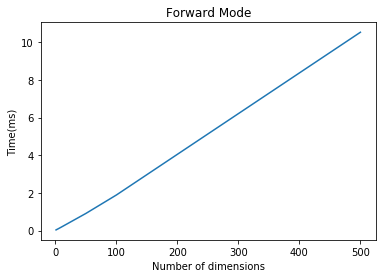

In [943]:
plt.plot(dimensions,time_fw)
plt.xlabel("Number of dimensions")
plt.ylabel("Time(ms)")
plt.title("Forward Mode")

## Backward mode

In [26]:
def do_backward_multidim(dim, T):
    lr = 0.1 # Outer learning rate
    ilr = 0.1 # Inner learning rate
    x = Variable(torch.randn(dim), requires_grad=True)
    y = Variable(torch.randn(dim), requires_grad=True)
    ##
    yt = torch.zeros(T, y.shape[0])

    for i in range(T):
        # We nee to compute the total derivative of f wrt x
        ##    
        for j in range(T):
            grad_y = torch.autograd.grad(gm(x,y), y, create_graph=True)[0]
            new_y = y - ilr*grad_y
            y = Variable(new_y, requires_grad=True)
            yt[j] = y
        ###
        alpha = -torch.autograd.grad(fm(x,y), y, retain_graph=True)[0]
        gr = torch.zeros_like(alpha)
        ###
        for j in range(T-1,-1,-1):
            y_tmp = Variable(yt[j], requires_grad=True)
            grad_y, = torch.autograd.grad( gm(x,y_tmp), y_tmp, create_graph=True )
            loss = y_tmp - ilr*grad_y
            loss = loss@alpha
            aux1 = torch.autograd.grad(loss, x, retain_graph=True)[0]
            aux2 = torch.autograd.grad(loss, y_tmp)[0]
            gr -= aux1
            alpha =aux2 

        grad_x = torch.autograd.grad(fm(x,y), x)[0] 
        ##
        x = x - lr*(grad_x + gr)

In [27]:
dimensions = np.array([1,2,5,10,50,100,500])
time_bw = np.zeros(len(dimensions))
sd_bw = np.zeros(len(dimensions))
##
for i, d in enumerate(dimensions):
    result = %timeit -o do_backward_multidim(int(d), 40)
    ts = result.average
    time_bw[i] = ts
    sd = result.stdev
    sd_bw[i] = sd

738 ms ± 65.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
735 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
769 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
870 ms ± 90.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
830 ms ± 88.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
769 ms ± 78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
826 ms ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
data = pd.DataFrame({"Time_Forward":time_fw, "Std_Forward":sd_fw,
                     "Time_Backward": time_bw, "Std_Backward": sd_bw,
                    "N": dimensions})

data.head()

,Time_Forward,Std_Forward,Time_Backward,Std_Backward,N
0,0.938118,0.070265,0.737736,0.065581,1
1,1.388932,0.195490,0.735050,0.137592,2
2,2.589588,0.245338,0.768834,0.131820,5
3,5.236286,0.362323,0.870149,0.090468,10
4,23.466005,0.728319,0.829966,0.088423,50


In [183]:
df_long = data.melt(id_vars=['N'])
df_long[['Qty', 'Type']] = df_long['variable'].str.split("_", n=1, expand=True)
df_wide = df_long.pivot_table(index=['N', 'Type'],
                              columns='Qty', values='value').reset_index()
df_wide

Qty,N,Type,Std,Time
0,1,Backward,0.065581,0.737736
1,1,Forward,0.070265,0.938118
2,2,Backward,0.137592,0.735050
3,2,Forward,0.195490,1.388932
4,5,Backward,0.131820,0.768834
5,5,Forward,0.245338,2.589588
6,10,Backward,0.090468,0.870149
7,10,Forward,0.362323,5.236286
8,50,Backward,0.088423,0.829966
9,50,Forward,0.728319,23.466005


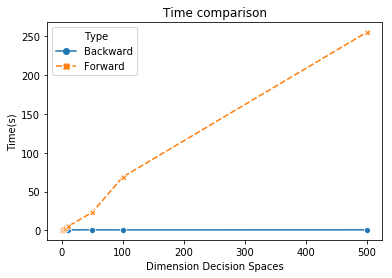

In [193]:
ax = sns.lineplot(x="N", y="Time",
                hue="Type", style="Type",
                markers=True, dashes=True, data=df_wide)

ax.set(xlabel='Dimension Decision Spaces', ylabel='Time(s)', title = 'Time comparison')
plt.savefig('time_comp.eps', format='eps', dpi = 1000)